In this notebook, we start by importing `data/loan.csv` credit data, featuring loan data from 2007-2015. Column description of data can be found in `data/LCDataDictionary.xlsx`. The data is part of [Lending Club Loan Data](https://www.kaggle.com/datasets/adarshsng/lending-club-loan-data-csv) on kaggle. 

- We first preprocess missing values, NaNs, and data types of variables and then perform EDA.

- Then dummy variables are created for categorical variables.

In [27]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import warnings
warnings.filterwarnings("ignore")

# Import data

In [28]:
# df_raw = pd.read_csv('data/loan.csv', nrows=5_00_000, engine='c') #keep a copy of data if needed
# df_raw.head()
# df = df_raw.copy()
df = pd.read_csv('data/loan.csv', nrows=5_00_000, engine='c') 

In [29]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Columns: 145 entries, id to settlement_term
dtypes: float64(59), int64(51), object(35)
memory usage: 553.1+ MB


In [30]:
df.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
       'disbursement_method', 'debt_settlement_flag',
       'debt_settlement_flag_date', 'settlement_status', 'settlement_date',
       'settlement_amount', 'settlement_percentage', 'settlement_term'],
      dtype='object', length=145)

We can select few columns from buisness logic to be independet variables

In [31]:
predictors = ['grade', 
              'home_ownership', 
              'purpose',
              'initial_list_status',
              'verification_status',
              'emp_length', 
              'term', 
              'int_rate',
              'dti',
              'annual_inc',
              'earliest_cr_line',
              'funded_amnt',
              'mths_since_last_record', 
              'addr_state']

Duplicates

In [32]:
df.duplicated().sum()

np.int64(0)

Data types

In [33]:
for prd in predictors:
    print(prd + ":", df[prd].dtype)

grade: object
home_ownership: object
purpose: object
initial_list_status: object
verification_status: object
emp_length: object
term: object
int_rate: float64
dti: float64
annual_inc: float64
earliest_cr_line: object
funded_amnt: int64
mths_since_last_record: float64
addr_state: object


Notice that, `emp_length`, `earliest_cr_line`, and `term` is str, which should be int. Before correcting this, we check if there are any missing values is predictors

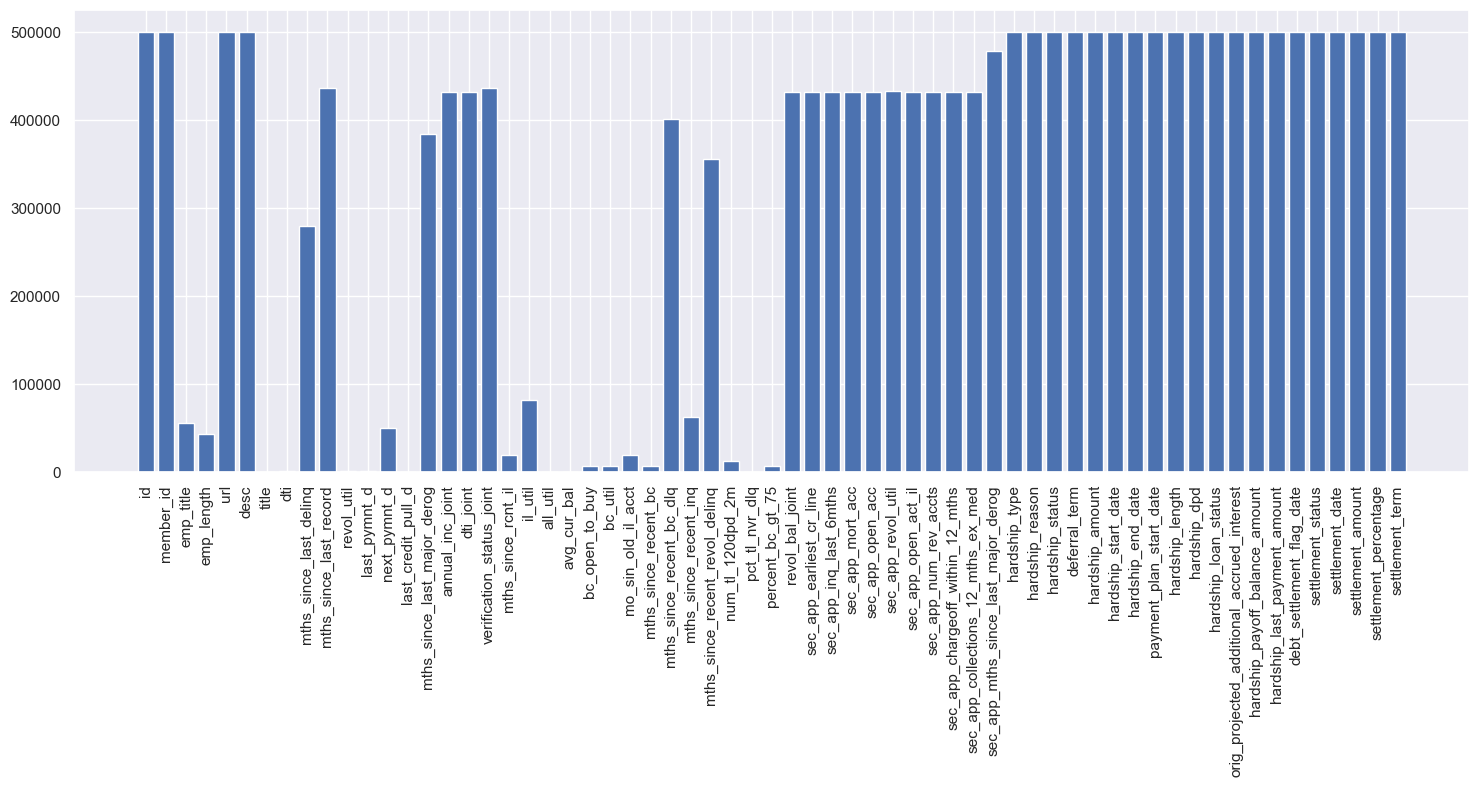

In [34]:
miss = df.isna().sum()
miss = miss[miss > 0]

plt.figure(figsize=(18,6))
plt.bar(miss.index, miss)
plt.xticks(rotation=90);

In [35]:
for prd in predictors:
    if prd in df.columns.values[df.isna().any()]:
        print(prd)

emp_length
dti
mths_since_last_record


In [36]:
#We fill the missing values with 0
df['emp_length'] = df['emp_length'].fillna(0)
df['dti'] = df['dti'].fillna(0)

We leave `mths_since_last_record` to be processed later

# Fix data types

In [37]:
df['emp_length'].unique() #get unique values

array(['10+ years', '6 years', '4 years', '< 1 year', '2 years',
       '9 years', 0, '5 years', '3 years', '7 years', '1 year', '8 years'],
      dtype=object)

In [38]:
#we use regex to filter the number and the fill NaNs with 0
df['emp_length_int'] = df['emp_length'].str.extract(r'(\d+)').fillna(0).astype(int) 
df['emp_length_int'].unique()

array([10,  6,  4,  1,  2,  9,  0,  5,  3,  7,  8])

In [39]:
df['term'].unique()

array([' 36 months', ' 60 months'], dtype=object)

In [40]:
df['term_int'] = df['term'].str.extract(r'(\d+)').astype(int) #same as before
df['term_int'].unique()

array([36, 60])

In [41]:
df['earliest_cr_line'] #better format is pd datetime

0         Apr-2001
1         Jun-1987
2         Apr-2011
3         Feb-2006
4         Dec-2000
            ...   
499995    Jan-1999
499996    Jul-2002
499997    Jul-2002
499998    Mar-2002
499999    Nov-1994
Name: earliest_cr_line, Length: 500000, dtype: object

In [42]:
df['earliest_cr_line_date'] = pd.to_datetime(df['earliest_cr_line'], format='%b-%Y')
df['earliest_cr_line_date']

0        2001-04-01
1        1987-06-01
2        2011-04-01
3        2006-02-01
4        2000-12-01
            ...    
499995   1999-01-01
499996   2002-07-01
499997   2002-07-01
499998   2002-03-01
499999   1994-11-01
Name: earliest_cr_line_date, Length: 500000, dtype: datetime64[ns]

In [43]:
df['earliest_cr_line_date'].max() #Till when data is collected

Timestamp('2015-11-01 00:00:00')

Following convention of some of the columns like `mths_since*`, we covert this to months passed conisdering `2015-12-01` as a reference date

In [44]:
df['mths_since_earliest_cr_line'] = round((pd.to_datetime('2015-12-01') - df['earliest_cr_line_date']) / np.timedelta64(30, 'D')) #convert to months
df['mths_since_earliest_cr_line']

0         179.0
1         347.0
2          57.0
3         120.0
4         183.0
          ...  
499995    206.0
499996    163.0
499997    163.0
499998    167.0
499999    257.0
Name: mths_since_earliest_cr_line, Length: 500000, dtype: float64

In [45]:
predictors

['grade',
 'home_ownership',
 'purpose',
 'initial_list_status',
 'verification_status',
 'emp_length',
 'term',
 'int_rate',
 'dti',
 'annual_inc',
 'earliest_cr_line',
 'funded_amnt',
 'mths_since_last_record',
 'addr_state']

<Axes: >

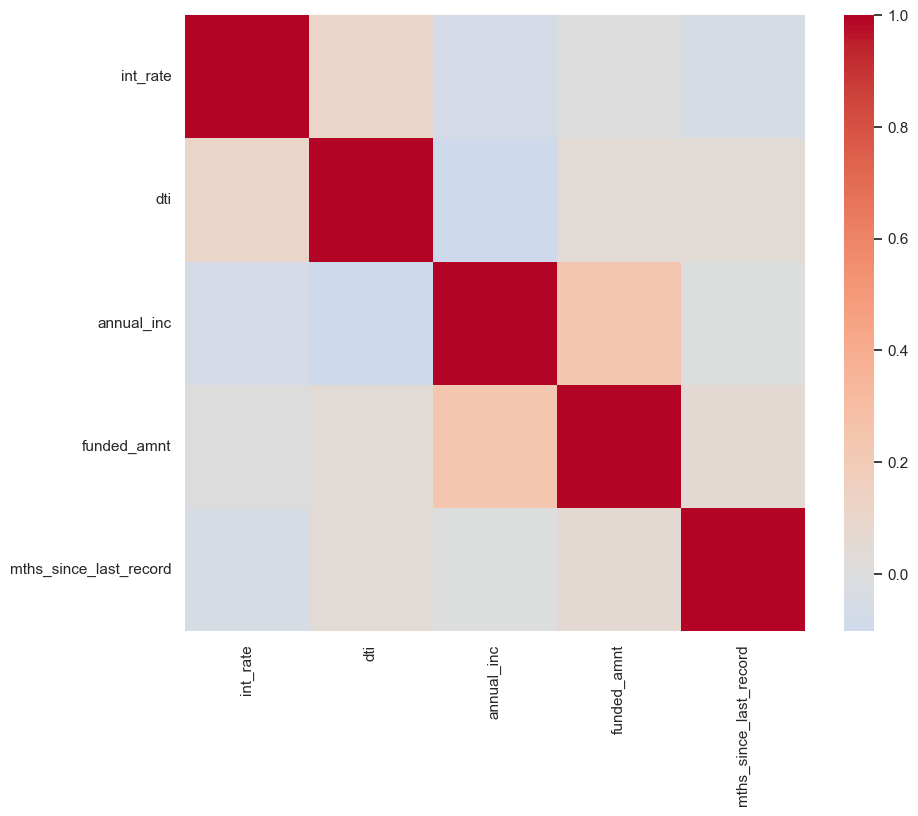

In [46]:
corr = df[predictors].corr(numeric_only=True)
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap='coolwarm', center=0)

We see there is not much correlation between our features, as presence of correlation can lead to redundancy, multicollinearity, and reduced model interpretability.

# Process categorical variables

- For binary classification, categorical variables are converted into dummy variables, which take values of either 0 or 1. 

- Thus, a categorical variable with $k$ categories is represented by $k$ binary columns, each indicating the presence (1) or absence (0) of a category. Note that for regression, we will only use ($k-1$) dummy variables to avoid multicollinearity

- A convenient method is `pd.get_dummies`

In [47]:
pd.get_dummies(df['grade'], prefix='grade', prefix_sep=':')

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G
0,False,False,True,False,False,False,False
1,False,False,False,True,False,False,False
2,False,False,False,True,False,False,False
3,False,False,False,True,False,False,False
4,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...
499995,False,True,False,False,False,False,False
499996,True,False,False,False,False,False,False
499997,False,True,False,False,False,False,False
499998,False,False,False,False,False,True,False


We do the same for all categorical variables

In [48]:
df_dummies = [pd.get_dummies(df['grade'], prefix='grade', prefix_sep=':'),
                pd.get_dummies(df['sub_grade'], prefix='sub_grade', prefix_sep=':'),
                pd.get_dummies(df['home_ownership'], prefix='home_ownership', prefix_sep=':'),
                pd.get_dummies(df['verification_status'], prefix='verification_status', prefix_sep=':'),
                pd.get_dummies(df['loan_status'], prefix='loan_status', prefix_sep=':'),
                pd.get_dummies(df['purpose'], prefix='purpose', prefix_sep=':'),
                pd.get_dummies(df['addr_state'], prefix='addr_state', prefix_sep=':'),
                pd.get_dummies(df['initial_list_status'], prefix='initial_list_status', prefix_sep=':'),
                ] #list of all dummy dfs 

df_dummies = pd.concat(df_dummies, axis=1) #join them together
df_dummies

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,sub_grade:A1,sub_grade:A2,sub_grade:A3,...,addr_state:TX,addr_state:UT,addr_state:VA,addr_state:VT,addr_state:WA,addr_state:WI,addr_state:WV,addr_state:WY,initial_list_status:f,initial_list_status:w
0,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,True
4,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
499996,True,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
499997,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
499998,False,False,False,False,False,True,False,False,False,False,...,False,False,True,False,False,False,False,False,False,True


In [49]:
df = pd.concat([df, df_dummies], axis=1) #concate with main dataframe

### Identify target variable

- In our data, `loan_status` indicates if the borrower has defaulted or not. This is the target variable we want to predict. 

- Being risk-aware, we consider late payments with highest risk, so here they are considered equivalent to default.

Our convention is
* Default: 0 (bad borrower)
* Not deafult: 1 (good borrower)

In [50]:
df['loan_status'].unique()

array(['Current', 'Fully Paid', 'Late (31-120 days)', 'In Grace Period',
       'Charged Off', 'Late (16-30 days)', 'Default'], dtype=object)

In [51]:
#Deafault, Charge off, and Late > 31 days is set to bad borrower (0), 
#otherwise its a good borrower (1) 
df['good_bad'] = np.where(df['loan_status'].isin(['Charged off',
                                                  'Default',
                                                  'Late (31-120 days)']), 
                                                  0, 1) 

df['good_bad'].value_counts()

good_bad
1    493426
0      6574
Name: count, dtype: int64

We see very few bad borrowers compared to good ones -- this is expected in real life. Know as class imbalance, this can lead to poor regression analysis. 

- Simple solutions can be to either oversample bad or undersample good data.

- Algorithmically, one can also reweight the loss function acc to sample data i.e. $L = w_{\text{good}} L_{\text{good}} + w_{\text{bad}} L_{\text{bad}}$ 

- Strong predictors also reduces imbalance impact

In [52]:
df.to_csv('data/loan_afterEDA.csv') #save for csv